# Estudo de Caso 3: Tolerancia do investidor ao Risco e Robos Advisors

* Criar um modelo capaz de prever a tolerancia ao risco de um investidor.
* Criar uma dashboard do robo advisor

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet
)

from sklearn.tree      import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm       import SVR

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)

from sklearn.neural_network import MLPRegressor

# Para analise de dados e a avaliacao de modelos
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2, f_regression
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# RNA
import tensorflow as tf
import keras


In [2]:
data = pd.read_excel('dataset/SCFP2009panel.xlsx')

In [3]:
data.head(2)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57


### Preparando a variavel prevista 

1. Compute os ativos arricados e sem risco para todos os individuos nos dados da pesquisa
    * Ativos arricados : fundos mutuos.ações e titulos
    * Ativos sem risco : conta-corrente e poupança, certificados de deposito e outros saldo em caixa

In [4]:
# Computar os ativos arriscados e não arriscado para 2007
data['RiskFree07'] = data['LIQ07'] + data['CDS07'] + data['SAVBND07'] + data['CASHLI07']
data['Risk07'] = data['NMMF07'] + data['STOCKS07'] + data['BOND07']

In [5]:
# Computar os ativos arriscados e não arriscado para 2009
data['RiskFree09'] = data['LIQ09'] + data['CDS09'] + data['SAVBND09'] + data['CASHLI09']
data['Risk09'] = data['NMMF09'] + data['STOCKS09'] + data['BOND09']

In [6]:
# Computa a torelancia ao risco
data['RT07'] = data['Risk07']/(data['Risk07'] + data['RiskFree07'])

In [7]:
Avg_SP500_2007 = 1478
Avg_SP500_2009 = 948

In [8]:
# Computa a tolrancia ao risco para 2009
data['RT09'] = data['Risk09']/(data['Risk09'] + data['RiskFree09'])*(Avg_SP500_2009/Avg_SP500_2007) 

In [9]:
# Percentual de torência ao risco
data['PercentageChange'] = np.abs(data['RT09'] / data['RT07'] - 1)

In [10]:
data.dropna(inplace=True)

In [11]:
data= data[~data.isin([np.inf, -np.inf]).any(axis=1)]

Invertigaremos o comportamento de tolerancia ao risco das pessoas em 2007

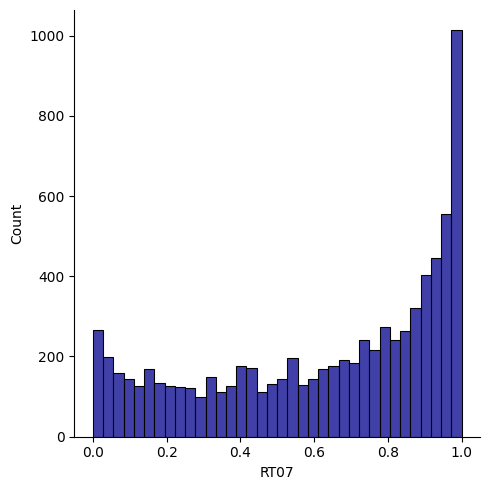

In [12]:
sns.displot(
    data['RT07'], kind='hist', kde=False, bins=int(180/5), color='darkblue'
)

> Em 2007 , vemos um numero significativo de pessoas teve tolerancia ao risco perto de 1, ou seja, seus investimentos estavam perdendo mais para os ativos arriscados.

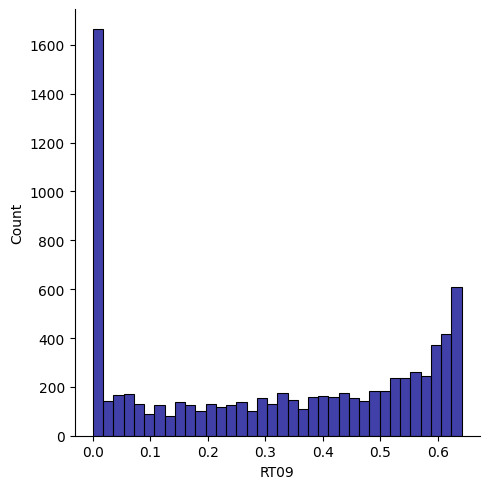

In [13]:
sns.displot(
    data['RT09'], kind='hist', kde=False, bins=int(180/5), color='darkblue'
)

> Foi revertido dps da crise

Vamos pegar os insvestidores inteligentes cuja alteração na torelacia de risco entre 2009 e 2007 ficou abaixo de 10%

In [14]:
data = data[data['PercentageChange'] <= .1]

In [15]:
data['TrueRiskTolerancia'] = (data['RT09'] + data['RT07'])/2

In [16]:
data['TrueRiskTolerancia'].value_counts()

TrueRiskTolerancia
0.479110    5
0.422015    5
0.293300    5
0.441075    5
0.412034    5
           ..
0.436557    1
0.654302    1
0.001832    1
0.076191    1
0.357442    1
Name: count, Length: 237, dtype: int64

Remonvendo colunas que não necessaria para previsão

In [17]:
data.drop(columns=['RT07', 'RT09', 'PercentageChange'], inplace=True)

Nos dados ha mais de 500 features no conj. de dados. No entanto, a literatura academica e a pratica do setor indicam que a tolarancia ao ricos é altamente influenciada pelos atributos :
* Demograficos
* Financeiros
* Comportamentais do investidor
* idade
* renda atual
* capital liquido
* disposição em assumir riscos


**AGE**

* Tipo: numérico (inteiro)
* Descrição: Idade em anos.
* Ex.: 23, 45, 67.
* Notas: valores inválidos/ausentes: `NA` ou `99`.

**EDUC**

* Tipo: categórica ordinal (inteiro)
* Descrição: Grau de instrução.
* Códigos:

  * `1` = Ensino fundamental incompleto
  * `2` = Ensino fundamental completo
  * `3` = Ensino médio completo
  * `4` = Ensino superior completo
* Notas: ajustar se o dataset usar categorias diferentes (ex.: pós-graduação).

**MARRIED**

* Tipo: binária (inteiro)
* Descrição: Estado civil (simplificado).
* Códigos:

  * `1` = Casado(a)
  * `2` = Não casado(a) (solteiro, separado, viúvo, etc.)
* Notas: se tiver categoria para `divorced` ou `widowed` separar.

**OCCU**

* Tipo: categórica (inteiro)
* Descrição: Ocupação / classificação ocupacional.
* Códigos sugeridos:

  * `1` = Gerencial / cargos de gestão
  * `2` = Profissional / técnico (ex.: engenheiro, professor)
  * `3` = Operacional / serviços / comércio (ex.: operário, vendedor)
  * `4` = Desempregado
* Notas: você pode mapear mais fine-grained se o raw tiver códigos detalhados.

**KIDS**

* Tipo: numérico (inteiro)
* Descrição: Número de filhos dependentes no domicílio.
* Ex.: `0`, `1`, `2`, `3+` (pode usar `3` literal ou `3+` representado por `3` e uma flag alternativa).
* Notas: tratar `NA` e valores extremos.

**WSAVED**

* Interpretação/assunção: *wealth saved* ou *willingness to save* — vou assumir **indicador se tem poupança / ativos líquidos**. Se no seu dicionário significar outra coisa, me diz.
* Tipo: binária (inteiro) ou contínua (se for valor monetário)
* Se binária (sugestão):

  * `0` = Não tem poupança / zero ativos líquidos
  * `1` = Tem poupança / ativos líquidos > 0
* Se contínua: pode ser valor em moeda (ex.: reais).
* Notas: confirmar unidade (BRL?) e tratamento de outliers.

**NWCAT**

* Interpretação/assunção: *net worth category* (categoria de riqueza / patrimônio líquido) — categoria ordinal.
* Tipo: categórica ordinal (inteiro)
* Códigos sugeridos:

  * `1` = Muito baixo (quase nenhuma riqueza)
  * `2` = Baixo
  * `3` = Médio
  * `4` = Alto
  * `5` = Muito alto
* Notas: ajustar número de classes conforme dataset original.

**INCCL**

* Interpretação/assunção: *income class* (classe de renda) — categoria ordinal.
* Tipo: categórica ordinal (inteiro)
* Códigos sugeridos:

  * `1` = Muito baixa renda
  * `2` = Baixa renda
  * `3` = Renda média
  * `4` = Alta renda
  * `5` = Muito alta renda
* Notas: se tiver faixa de renda em valores, converter para classes com cortes (quantis ou limites absolutos).

**RISK**

* Interpretação/assunção: tolerância a risco / aversão ao risco — escala.
* Tipo: ordinal (inteiro)
* Códigos sugeridos: (escala Likert 1–5)

  * `1` = Muito avesso ao risco
  * `2` = Averso ao risco
  * `3` = Neutro / moderado
  * `4` = Propenso ao risco
  * `5` = Muito propenso ao risco
* Notas: se RISK for medido por percentuais ou scores, trate como contínua.

In [18]:
keep_list = ['AGE07', 'EDCL', 'MARRIED07', 'KIDS07', 'OCCAT107', 'INCOME07', 'RISK07', 'NETWORTH07', 'TrueRiskTolerancia']

In [19]:
drop_cols = [
    col for col in data.columns if col not in keep_list
]

In [20]:
data = data.drop(columns=drop_cols)

In [21]:
data

,AGE07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerancia
60,77,1,0,3,3.141680e+04,4,2.152490e+05,0.199511
425,55,1,1,2,2.779588e+06,2,4.964759e+07,0.641458
1122,85,1,0,2,3.727417e+05,4,5.837768e+07,0.589943
1190,40,1,3,1,5.324882e+04,3,2.688929e+05,0.434127
1228,70,1,0,2,3.716767e+04,3,2.015066e+06,0.228218
...,...,...,...,...,...,...,...,...
19190,53,1,0,1,1.810460e+05,2,7.580575e+05,0.352094
19191,53,1,0,1,1.821109e+05,2,7.570219e+05,0.357442
19192,53,1,0,1,1.810460e+05,2,7.580575e+05,0.352094
19193,53,1,0,1,1.810460e+05,2,7.580575e+05,0.352094


<Axes: >

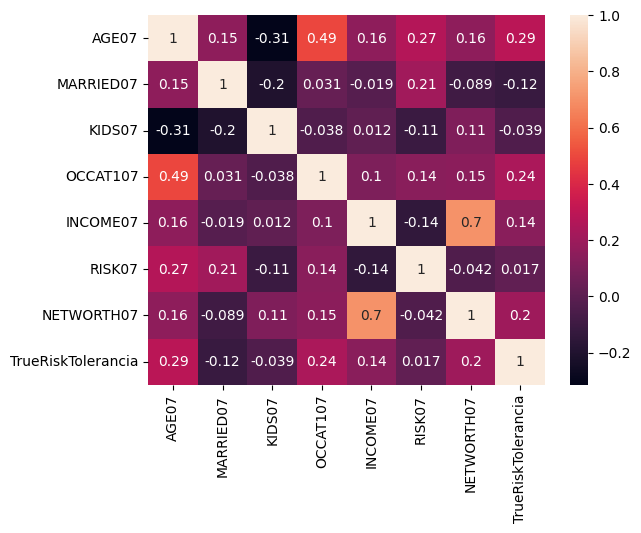

In [22]:
sns.heatmap(data.corr(), annot=True)

`Treinando os modelos`

In [23]:
models = []

models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('KNeighbors', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('MLP', MLPRegressor()))